# Symbolic execution

### Alessandro Bruni
### Ethical Hacking, Mar 8 2023

Today we look at another way for automating exploitation: is symbolic execution

### Reading material:
- [Valgrind documentation](https://valgrind.org/docs/manual/index.html)
- [Angr.io documentation](https://angr.io/)


# Uniform program representation

# Problem
- we have programs in many different formats
- often in offensive security no access to sources
- if we want to analyze code we need an uniform way to represent it, so to reuse the analysis on different platform

# Example

```c
int main(int argc, char**argv) {
	if (argc > 1 && strcmp(argv[1], "Th3s3cr37") == 0) {
		printf("You got me\n");
	} else {
		printf("No way!\n");
	}
}
```

# x86
```
main:
.LFB0:
	.cfi_startproc
	pushq	%rbp
	.cfi_def_cfa_offset 16
	.cfi_offset 6, -16
	movq	%rsp, %rbp
	.cfi_def_cfa_register 6
	subq	$16, %rsp
	movl	%edi, -4(%rbp)
	movq	%rsi, -16(%rbp)
	cmpl	$1, -4(%rbp)
	jle	.L2
	movq	-16(%rbp), %rax
	addq	$8, %rax
	movq	(%rax), %rax
	movl	$.LC0, %esi
	movq	%rax, %rdi
	call	strcmp
	testl	%eax, %eax
	jne	.L2
	movl	$.LC1, %edi
	call	puts
	jmp	.L3
.L2:
	movl	$.LC2, %edi
	call	puts
.L3:
	movl	$0, %eax
	leave
	.cfi_def_cfa 7, 8
	ret
	.cfi_endproc
```

# ARM
```
main:
	push	{fp, lr}
	add	fp, sp, #4
	sub	sp, sp, #8
	str	r0, [fp, #-8]
	str	r1, [fp, #-12]
	ldr	r3, [fp, #-8]
	cmp	r3, #1
	ble	.L2
	ldr	r3, [fp, #-12]
	add	r3, r3, #4
	ldr	r3, [r3]
	ldr	r1, .L5
	mov	r0, r3
	bl	strcmp
	mov	r3, r0
	cmp	r3, #0
	bne	.L2
	ldr	r0, .L5+4
	bl	puts
	b	.L3
.L2:
	ldr	r0, .L5+8
	bl	puts
.L3:
	mov	r3, #0
	mov	r0, r3
	sub	sp, fp, #4
	@ sp needed
	pop	{fp, lr}
	bx	lr
```

# Instrumentation


# Idea
- all machines (CPUs or VMs) operate in a very similar way
- they all have:
    - *registers* (just one accumulator for stack machines like JVM/.NET CLR, a fixed number like in x86/ARM, an infinite number like in DEX/Android and LLVM-IR)
    - a *stack*
    - a *heap*
- they all do:
    - *load/store* operations between registers and RAM (x86 does this implicitly)
    - *math* operations (e.g. addition, subtraction, logical and/or/xor)
    - *control* operations (branching, function call/return)
## Let's generalize!

### Enter Valgrind/VEX
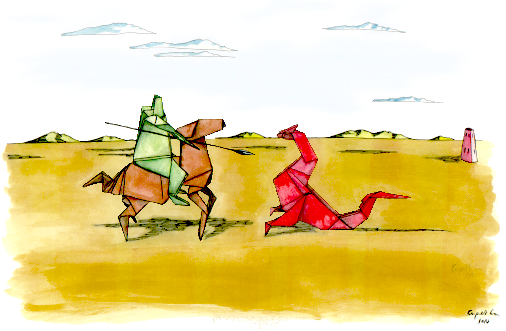

# VEX
- there are many intermediate representations that try to generalize CPU codes, tailored at different use cases (e.g. [LLVM](https://llvm.org/docs/LangRef.html), radare's [ESIL](https://radare.gitbooks.io/radare2book/content/disassembling/esil.html), [BAP's IR](https://github.com/BinaryAnalysisPlatform/bap), [VEX](https://docs.angr.io/advanced-topics/ir))
- VEX is tailored towards accurate execution and instrumentation of code

### Example
The following ARM instruction:

```
subs R2, R2, #8
```

Becomes this VEX IR:
```
t0 = GET:I32(16)
t1 = 0x8:I32
t3 = Sub32(t0,t1)
PUT(16) = t3
PUT(68) = 0x59FC8:I32
```

# Let's play with VEX

In [1]:
import angr, claripy
project = angr.Project("examples/ex01")

In [2]:
irsb = project.factory.block(0x0000000000401136).vex
irsb.pp()

IRSB {
   t0:Ity_I64 t1:Ity_I64 t2:Ity_I64 t3:Ity_I64 t4:Ity_I64 t5:Ity_I64 t6:Ity_I64 t7:Ity_I32 t8:Ity_I32 t9:Ity_I32 t10:Ity_I64 t11:Ity_I64 t12:Ity_I64 t13:Ity_I64 t14:Ity_I64 t15:Ity_I64 t16:Ity_I32 t17:Ity_I64 t18:Ity_I64 t19:Ity_I64 t20:Ity_I64 t21:Ity_I64 t22:Ity_I64 t23:Ity_I64 t24:Ity_I64 t25:Ity_I1 t26:Ity_I64 t27:Ity_I64 t28:Ity_I64 t29:Ity_I64 t30:Ity_I64 t31:Ity_I64 t32:Ity_I32 t33:Ity_I64 t34:Ity_I64 t35:Ity_I1 t36:Ity_I32 t37:Ity_I32 t38:Ity_I1

   00 | ------ IMark(0x401136, 1, 0) ------
   01 | t0 = GET:I64(rbp)
   02 | t12 = GET:I64(rsp)
   03 | t11 = Sub64(t12,0x0000000000000008)
   04 | PUT(rsp) = t11
   05 | STle(t11) = t0
   06 | ------ IMark(0x401137, 3, 0) ------
   07 | PUT(rbp) = t11
   08 | ------ IMark(0x40113a, 4, 0) ------
   09 | t2 = Sub64(t11,0x0000000000000010)
   10 | PUT(rsp) = t2
   11 | PUT(rip) = 0x000000000040113e
   12 | ------ IMark(0x40113e, 3, 0) ------
   13 | t14 = Add64(t11,0xfffffffffffffffc)
   14 | t17 = GET:I64(rdi)
   15 | t32 = 64to

# Analyses

Once we have a way to represent arbitrary binary files we can:
- run static analysis
- instrument the code
- fuzz the binary
- run dynamic analysis

# Static analysis
Most useful at compile time, but can be run also on binaries.
The basic idea: describe mathematically a piece of code and learn interesting properties instead of running it.

If interested for an introduction, check this book:
[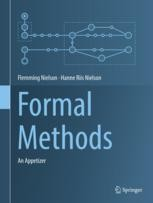](https://www.springer.com/gp/book/9783030051556) 

# Example: null-pointer analysis
```c
#include <stdio.h>

void main(void) {
    char *s = NULL;
    *s = 'x';
}
```

what happens if we run this?

# Bad news!

## Rice's theorem:

All non-trivial, semantic properties of programs are undecidable

# Good news!

## Bruni's postulates:
- We have jobs for the foreseable future :)
- And we have tools that can help us

# Dynamic analyses
If we cannot decide things statically, then we can:
- instrument and run the code
- fuzz the binary
- run symbolic execution

# Binary instrumentation

- take the IR of a program and change it as to reveal software flaws
- e.g. add memory bounds checking to every memory access, to find potential buffer overflows
- look at https://www.valgrind.org/info/tools.html for different analyses

## Limitation
- triggering flaws requires that we execute all code paths
- one can use unit tests or..

# Fuzzying

[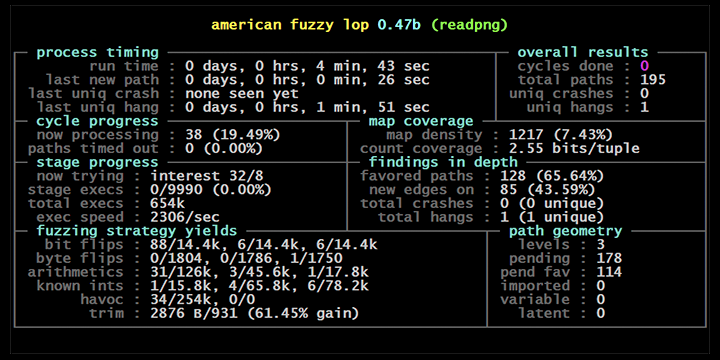](https://lcamtuf.coredump.cx/afl/)

- American Fuzzy Lop is a *coverage based fuzzer*: it runs the program with different inputs to find failure states
- Basic: random fuzzying
- More advanced: guided fuzzying with *input grammars*, *genetic input generation* to improve coverage and accelerate search
- Ultimately, the approach is limited: it relies on randomization to find new path, so certain "rare" paths are hard to find

## Example
```c
int main(void) {
    char buf[32];
    char *data = read_string();
    unsigned int magic = read_number();

    if (magic == 0x31337987) {
        memcpy(buf, data, 100); // buffer overflow
    }
}
```

# Symbolic execution

Idea: augment code coverage by building a set of constraints on the input that allow to choose a specific path

## Example
```c
int main(void) {
    char buf[32];
    char *data = read_string();
    unsigned int magic = read_number();

    if (magic == 0x31337987) {
        memcpy(buf, data, 100); // buffer overflow
    }
}
```

- To reach the buffer overflow, we add the constraint that `magic == 0x31337987`

- We can treat every decision point as a branch on a tree, and try to explore all possible branches.

# [SMT solvers](https://en.wikipedia.org/wiki/Satisfiability_modulo_theories)
- SMT stands for Satisfiability Modulo Theory
- essentially solving the SAT problem (known NP-complete but efficient solutions are available) where each atom relies on a theory
- SAT: e.g. $(a \vee b \vee c) \wedge (\lnot a \vee b) \wedge (\lnot b)$
- theories: empty theory, linear arithmetic, nonlinear arithmetic, bitvectors, arrays, datatypes, quantifiers, strings (from Z3)

In [3]:
from z3 import *
x = Real('x'); y = Real('y')
s = Solver()
s.add(x < 10)
s.add(y > x)
print(s.check())
s.model()

sat


[y = 1, x = 0]

# Symbolic execution (cont.)

- once we have a tool to express path constraints (SMT) we can implement any search procedure for the branch tree: DFS, BFS, etc

# Simple Symbolic Execution (from [GIST](https://gist.github.com/hoheinzollern/409f9aae52b96b770ad8959f8e4c496b))

- dynamic languages support easy instrumentation
- proxy objects: they simulate the interface of "real" objects but add new functionality

In [ ]:
def find_path(path, f, *args, **kwargs):
    log = []
    def unwrap(other):
        try:
            return other.v
        except:
            return other
    class Sym:
        def __init__(self, v):
            self.v = v
            
        def __repr__(self):
            return self.v.__repr__()

        # Arithmetic operators
        def __add__(self, other):
            return Sym(self.v.__add__(unwrap(other)))

        def __sub__(self, other):
            return Sym(self.v.__sub__(unwrap(other)))

        def __mul__(self, other):
            return Sym(self.v.__mul__(unwrap(other)))

        def __div__(self, other):
            return Sym(self.v.__div__(unwrap(other)))

        def __neg__(self):
            return Sym(self.v.__neg__())
    
        # Comparison operators
        def __eq__(self, other):
            return Sym(self.v.__eq__(unwrap(other)))

        def __ne__(self, other):
            return Sym(self.v.__ne__(unwrap(other)))

        def __le__(self, other):
            return Sym(self.v.__le__(unwrap(other)))
        
        def __ge__(self, other):
            return Sym(self.v.__ge__(unwrap(other)))

        def __lt__(self, other):
            return Sym(self.v.__lt__(unwrap(other)))

        def __gt__(self, other):
            return Sym(self.v.__gt__(unwrap(other)))

        # Boolean operators
        def __and__(self, other):
            return Sym(And(self.v, unwrap(other)))

        def __or__(self, other):
            return Sym(Or(self.v, unwrap(other)))

        def __not__(self):
            return Sym(Not(self.v))

        # This is the crucial bit: when we evaluate a boolean
        # expression, we check what branch we need to take (true or
        # false), and add a constraint to the solver accordingly
        def __bool__(self):
            if path.pop():
                log.append(self.v)
                return True
            else:
                log.append(Not(self.v))
                return False

    f(*map(Sym,args), **kwargs)
    print(log)
    s = Solver()
    map(lambda x: s.add(x), log)
    if s.check().r == 1:
        print(s.model())
    else:
        print('unsat')

def f(x, y):
    x = x + y*2
    print(x)
    if x == 5:
        z = 0
    else:
        z = 1

find_path([False], f, Real('x'), Real('y'))

# Concolic execution in Angr

- [angr.io](https://docs.angr.io/) is a framework for running analyses that puts together all the concepts above, and more
- *concolic execution*: mixes symbolic constraints and concrete inputs to improve coverage
- you can implement your own search procedure

## Example:
```c
int main(void) {
    char buf[32];
    char *data = read_string();
    unsigned int magic = read_number();

    if (magic == 0x31337987) {  // difficult check for fuzzing
        memcpy(buf, data, 100); // buffer overflow
    }

    if (magic < 100 && magic % 15 == 2 && magic % 11 == 6) {
        // Only solution is 17; safe
        memcpy(buf, data, magic);
    }
    
    // Symbolic execution will suffer from path explosion
    int count = 0;
    for (int i = 0; i < 100; i++) {
        if (data[i] == 'Z') {
            count++;
        }
    }

    if (count >= 8 && count <= 16) {
        memcpy(buf, data, count*20); // buffer overflow
    }
}
```

In [ ]:
argv = claripy.BVS('argv', 10*0x8)
state = project.factory.entry_state(args = ['ex01', argv])
simgr = project.factory.simgr(state)
simgr.explore(find = lambda s: b'You got me' in s.posix.dumps(1))
print(simgr.found[0].solver.eval(argv, cast_to = bytes))

In [ ]:
project = angr.Project("examples/ex02")
state = project.factory.entry_state()
simgr = project.factory.simgr(state)
simgr.explore(find = 0x00401245)#lambda s: b'You got it' in s.posix.dumps(1))
simgr.found[0].posix.dumps(0)

In [ ]:
cfg = project.analyses.CFGEmulated(keep_state=True)
print(cfg.edges)

# Program slices

In [ ]:
def fibandfact(n):
    a,b = 1,1
    c = 1
    for i in range(n):
        a,b = a+b,a
        c = c*(i+1)
    return b,c

def fib(n):
    a,b = 1,1
    for i in range(n):
        a,b = a+b,a
    return b

def fact(n):
    c = 1
    for i in range(n):
        c = c*(i+1)
    return c

fibandfact(100) == (fib(100), fact(100))